# Trident Implementation
- Putting together all the functions for trident.
- To b cleaned later if the code works

In [89]:
import jax
from jax import grad, jit, vmap
import jax.numpy as jnp
import optax
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from tqdm.notebook import tqdm

from sklearn.datasets import make_moons

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

In [71]:
DATA_PATH = f"/Users/vikrantjaltare/OneDrive - UC San Diego/Datasets/"
FIGURES_PATH = f"/Users/vikrantjaltare/OneDrive - UC San Diego/Figures/onr_figures/"

# Network initialization

In [10]:
## initialize layers
def init_network_params(input_shape, output_shape, key = jax.random.key(0)):
    """
    Xavier initialization of weights and zeros for biases
    """

    key, param_key = jax.random.split(key)

    W = jax.random.normal(param_key, (output_shape, input_shape)) * jnp.sqrt(2/(input_shape + output_shape))
    b = jnp.zeros(output_shape)

    return W, b

## initialize network layers
def init_network_layers(sizes, key = jax.random.key(0)):
    """
    Initialize W and b for each layer. 
    sizes is a list of fc units
    """
    keys = jax.random.split(key, len(sizes))
    params = [init_network_params(n_in, n_out, key) for n_in, n_out, key in zip(sizes[:-1], sizes[1:], keys)]
    return params


Weight: [[ 0.4051021  -0.5872418 ]
 [ 0.9334137   0.08659133]
 [-0.51320326  0.08688625]], bias [0. 0. 0.]
Weight: [[ 0.16948457  0.3314338  -1.011883  ]
 [ 1.3737214  -0.07074335 -0.67105055]], bias [0. 0.]


# Activation function

In [30]:
## define ternary thresholding activation function
def ternary_activation(x, thresholds, noise_sd, key = jax.random.key(0)):
    """
    Ternary activation function
    """
    key, key2 = jax.random.split(key, 2)

    # generate noise
    noise = jax.random.normal(key = key2, shape = x.shape) * noise_sd

    # inject noise
    x = x + noise


    # threshold
    t1, t2 = thresholds
    s = jnp.where(
        x < t1, -1.0,
        jnp.where(
            x > t2, 1.0,
            0.0
        )
    )

    return s

## define binary thresholding function: states [-1, 1]
def binary_activation(x, threshold, noise_sd, key = jax.random.key(0)):
    """
    Binary activation function
    """
    key, key2 = jax.random.split(key, 2)

    # generate noise
    noise = jax.random.normal(key = key2, shape = x.shape) * noise_sd

    # inject noise
    x = x + noise

    s = jnp.where(
        x < threshold, -1.0, 1.0
    )

    return s


# Custom backward pass through expected state gradient

In [36]:
## helper function
@jax.jit
def gaussian_cdf(x, mu, sigma):
    return jax.scipy.stats.norm.cdf(x, loc = mu, scale = sigma)

@jax.jit
def gaussian_pdf(x, mu, sigma):
    return jax.scipy.stats.norm.pdf(x, loc = mu, scale = sigma)

@jax.jit
def expected_state(x, thresholds, noise_sd):
    t1, t2 = thresholds
    e = ((1 - gaussian_cdf(x = t2 - x, mu = 0, sigma = noise_sd)) - gaussian_cdf(x = t1 - x, mu = 0, sigma = noise_sd))
    return e

# custom gradients

@jax.custom_vjp
def custom_ternary_gradient(x, thresholds, noise_sd):
    return ternary_activation(x = x, thresholds = thresholds, noise_sd = noise_sd) # call the ternary activation in the forward pass

def custom_ternary_gradient_fwd(x, thresholds, noise_sd):
    return custom_ternary_gradient(x, thresholds, noise_sd), (x, thresholds, noise_sd) # save the inputs, thresholds, noise_sd for the backward pass

def custom_ternary_gradients_bwd(residuals, grads):
    x, thresholds, noise_sd = residuals # unpack the residuals from forward pass
    t1, t2 = thresholds
    exp_state_grad = gaussian_pdf(x = t1 - x, mu = 0, sigma = noise_sd) + gaussian_pdf(x = t2 - x, mu = 0, sigma = noise_sd)
    return (exp_state_grad*grads, None, None)

custom_ternary_gradient.defvjp(custom_ternary_gradient_fwd, custom_ternary_gradients_bwd)

Text(0, 0.5, 'Custom Gradient')

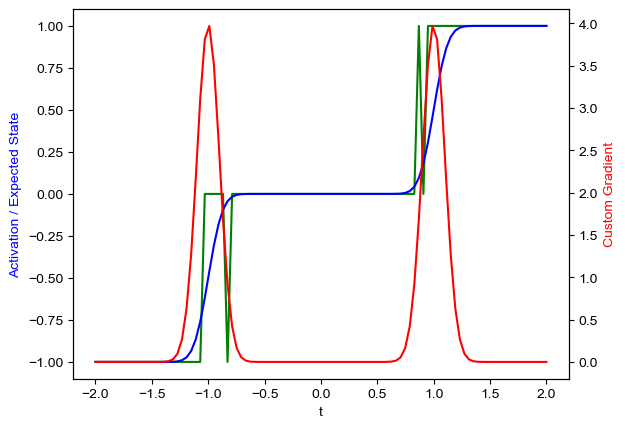

In [37]:
## testing
t = jnp.linspace(-2, 2, 100)
th = [-1.0, 1.0]
noise_sd = 0.1
act = ternary_activation(t, th, 0.1)
exp_st = expected_state(t, th, noise_sd)
cus_grad = jax.vmap(jax.grad(custom_ternary_gradient), in_axes=(0, None, None))(t, th, noise_sd)

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(t, act, 'g-')
ax1.plot(t, exp_st, 'b-')
ax2.plot(t, cus_grad, 'r-')

ax1.set_xlabel('t')
ax1.set_ylabel('Activation / Expected State', color='b')
ax2.set_ylabel('Custom Gradient', color='r')

# Forward pass, loss, updating parameters

In [61]:
## forward pass
def forward_ternary(params, input, thresholds, noise_sd, key = jax.random.key(100)):
    """
    Perform a forward pass through the network
    """

    activations = input
    act_hidden = []

    for i, (W, b) in enumerate(params[:-1]): # iterate through all layers except the last one
        key, split_key = jax.random.split(key)

        # linear transformation
        out = jnp.dot(W, activations) + b

        # pass through non-linearity
        activations = custom_ternary_gradient(out, thresholds, noise_sd)
        act_hidden.append(activations)

    # last layer
    W, b = params[-1]
    logits = jnp.dot(W, activations) + b
    # print(f"Hidden activations = {act_hidden}")
    return logits



# using vmap for batched predictions
batch_forward_ternary = vmap(forward_ternary, in_axes = (None, 0, None, None))


## loss function
def cross_entropy_loss(params, inputs, targets, thresholds, noise_sd):
    """
    Compute cross-entropy loss.
    Assume that labels are one-hot encoded
    """

    # run the forward pass
    logits = batch_forward_ternary(params, inputs, thresholds, noise_sd)

    # compute the softmax
    log_probits = jax.nn.log_softmax(logits)

    # compute the cross-entropy
    loss = -jnp.sum(log_probits * targets)

    # TODO: Add regularization

    return jnp.mean(loss)




In [101]:
## Testing cell
## test the forward pass: Uncomment to test!
example_input = jax.random.normal(key = jax.random.key(0), shape = (10, 5)) # dim: (num_batches x num_inputs)
example_params = init_network_layers([5, 10, 2])
example_thresholds = [-1.0, 1.0]
example_noise_sd = 0.1
# # example_forward = predict(example_params, example_input, example_thresholds, example_noise_sd, activation = 'ternary')
# trace_predict = jax.make_jaxpr(batch_forward_ternary)(example_params, example_input, example_thresholds, example_noise_sd)
# # print(trace_predict)
# print(forward_ternary(example_params, example_input[5], example_thresholds, example_noise_sd))
oo = batch_forward_ternary(example_params, example_input, example_thresholds, example_noise_sd)
print(oo)
# print(jax.nn.softmax(oo))

# test the loss function
example_targets = jax.random.randint(minval=0, maxval=2, shape = (10, 2), key = jax.random.key(0))
example_loss = cross_entropy_loss(example_params, example_input, example_targets, example_thresholds, example_noise_sd)
example_grad = jax.grad(cross_entropy_loss)(example_params, example_input, example_targets, example_thresholds, example_noise_sd)
print(f"Loss: {example_loss}")
for i, (gw, gb) in enumerate(example_grad):
    print(f"Layer = {i + 1} \n")
    print(f"Gradient W: {gw}, Gradient b: {gb}")
print(example_targets)

[[ 0.82240325  0.31659925]
 [ 0.4106468  -0.9141994 ]
 [-0.12999552  0.48730162]
 [ 0.59727687 -0.05963686]
 [-0.9941163  -0.08120256]
 [-0.4106468   0.9141994 ]
 [ 0.          0.        ]
 [ 0.45236433 -0.6622945 ]
 [-0.9523988   0.17070237]
 [ 0.82240325  0.31659925]]
Loss: 4.779211044311523
Layer = 1 

Gradient W: [[ 1.41248645e-11  1.35667241e-11 -3.65370199e-11 -6.98899532e-12
   7.21264576e-11]
 [ 4.44918768e-08  1.41008087e-07 -7.40734762e-08 -9.71533680e-08
   2.46992926e-07]
 [-3.69984567e-01 -1.58453786e+00  1.77496467e-02 -1.12509346e+00
  -4.93788421e-01]
 [ 6.50430751e-11  4.77029735e-11  7.10494684e-12 -3.70062965e-12
   2.71243011e-11]
 [-2.52920121e-01 -7.99362004e-01  4.25601900e-01  5.53311110e-01
  -1.40801525e+00]
 [ 1.19929336e-01 -6.66388720e-02 -3.86220306e-01  7.96004832e-02
   5.75896800e-01]
 [-2.30976678e-02  1.69580020e-02  7.61072785e-02 -1.84816681e-02
  -1.10086381e-01]
 [-4.88544375e-01 -1.65537453e+00  7.39304662e-01 -2.05715559e-02
  -2.02937198e+00]
 

In [105]:
print(jnp.argmax(oo, axis = 1))

[0 0 1 0 1 1 0 0 1 0]


# Loading data
- Import MNIST using tensoflow datasets

In [81]:
# tf.config.set_visible_devices([], device_type='GPU')

# # mention the batch_size
# batch_size = 128

# mnist_data, info = tfds.load(name="mnist", 
#                              batch_size = batch_size,
#                              data_dir=DATA_PATH, 
#                              with_info=True)

# mnist_data = tfds.as_numpy(mnist_data)

# # Extract train and test data
# train_data, test_data = mnist_data['train'], mnist_data['test']

# # Combine train and test data
# images = np.concatenate([train_data['image'], test_data['image']], axis=0)
# labels = np.concatenate([train_data['label'], test_data['label']], axis=0)

# # extract the number of pixels
# num_pixels = images.shape[1]*images.shape[2]

# # Shuffle the data
# indices = np.arange(images.shape[0])
# np.random.shuffle(indices)
# images = images[indices]
# labels = labels[indices]

# # Split the data
# train_images, train_labels = images[:50000], labels[:50000]
# train_images = jnp.reshape(train_images, (train_images.shape[0], num_pixels))
# valid_images, valid_labels = images[50000:60000], labels[50000:60000]
# valid_images = jnp.reshape(valid_images, (valid_images.shape[0], num_pixels))
# test_images, test_labels = images[60000:], labels[60000:]
# test_images = jnp.reshape(test_images, (test_images.shape[0], num_pixels))

# print(f"Train set: {train_images.shape}, {train_labels.shape}")
# print(f"Validation set: {valid_images.shape}, {valid_labels.shape}")
# print(f"Test set: {test_images.shape}, {test_labels.shape}")


In [127]:
BATCH_SIZE = 128


def load_and_preprocess_mnist(data_path, batch_size):
    """
    load mnist with splits and normalize
    """

    ds_train, ds_test = tfds.load('mnist', split=['train', 'test'], data_dir=data_path, as_supervised=True)

    # normalize and convert to numpy
    def normalize_image(image, label):
        image = tf.cast(image, tf.float32)/ 255.0
        return image, label
    
    ds_train = ds_train.map(normalize_image)
    ds_test = ds_test.map(normalize_image)

    # convert to numpy
    train_data = tfds.as_numpy(ds_train)
    test_data = tfds.as_numpy(ds_test)

    # separate images and samples
    train_images, train_labels = zip(*train_data)
    test_images, test_labels = zip(*test_data)

    # convert tuples to numpy arrays
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)
    test_images = np.array(test_images)
    test_labels = np.array(test_labels)

    # concatenate to create a single dataset
    images = np.concatenate([train_images, test_images], axis = 0)
    labels = np.concatenate([train_labels, test_labels], axis = 0)

    # split the data 50k-10k-10k
    train_images, val_images, test_images = images[:50000], images[50000:60000], images[60000:]
    train_labels, val_labels, test_labels = labels[:50000], labels[50000:60000], labels[60000:]

    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

def get_train_batches(train_images, train_labels, batch_size):
    ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    ds = ds.shuffle(len(train_images)).batch(batch_size).prefetch(1)
    return tfds.as_numpy(ds)


# load the data
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = load_and_preprocess_mnist(DATA_PATH, BATCH_SIZE)

## Helper functions

In [136]:
## define an accuracy function
def accuracy(params, images, targets, thresholds, key, noise_sd):
    """
    Calculate the accuracy of the model
    """
    # target_class = jnp.argmax(targets, axis = 1)
    # batch_forward_ternary(example_params, example_input, example_thresholds, example_noise_sd)
    pred = batch_forward_ternary(params, images, thresholds, noise_sd)
    pred = jnp.argmax(pred, axis = 1)
    # predicted_class = jnp.argmax(batch_forward_ternary(params, images, thresholds, key, noise_sd), axis = 1)
    mean_acc = jnp.mean(pred == targets)
    # print(pred, mean_acc)


    return mean_acc

## choose an optimizer
lr = 1e-3
optimizer = optax.sgd(learning_rate=1e-3)

def update_with_sgd(params, image, label, thresholds, noise_sd, opt_state):
  # compute gradients and update parameters
  loss, grads = jax.value_and_grad(cross_entropy_loss)(params, image, label, thresholds, noise_sd)
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  return params, opt_state, loss

In [137]:
# testing acuraracy
example_targets = jax.random.randint(minval=0, maxval=2, shape = example_input.shape[0], key = jax.random.key(0))
print(example_targets)
aa = accuracy(example_params, example_input, example_targets, example_thresholds, 100, example_noise_sd)

[0 1 1 0 1 1 0 1 0 0]


# Training loop

  0%|          | 0/10 [00:00<?, ?it/s]

[0 0 7 ... 0 2 6] 0.0929
[0 0 9 ... 2 0 6] 0.0902
Epoch 0, Train Acc: 0.09290000051259995, Valid Acc: 0.09019999951124191
[4 1 0 ... 4 3 9] 0.9223
[1 3 8 ... 6 1 5] 0.9181
Epoch 1, Train Acc: 0.9222999811172485, Valid Acc: 0.9180999994277954
[4 1 0 ... 9 3 9] 0.94637996
[1 3 8 ... 6 1 5] 0.9385
Epoch 2, Train Acc: 0.9463799595832825, Valid Acc: 0.9384999871253967
[4 1 0 ... 4 3 9] 0.95875996
[1 3 8 ... 6 1 5] 0.94659996
Epoch 3, Train Acc: 0.9587599635124207, Valid Acc: 0.9465999603271484
[4 1 0 ... 9 3 9] 0.96577996
[1 3 3 ... 6 1 5] 0.9514
Epoch 4, Train Acc: 0.9657799601554871, Valid Acc: 0.9513999819755554
[4 1 0 ... 9 3 9] 0.97323996
[1 3 8 ... 6 1 5] 0.95659995
Epoch 5, Train Acc: 0.9732399582862854, Valid Acc: 0.9565999507904053
[4 1 0 ... 9 3 9] 0.97845995
[1 3 8 ... 6 1 5] 0.95879996
Epoch 6, Train Acc: 0.9784599542617798, Valid Acc: 0.9587999582290649
[4 1 0 ... 9 3 9] 0.98227996
[1 3 8 ... 6 1 5] 0.9605
Epoch 7, Train Acc: 0.9822799563407898, Valid Acc: 0.9605000019073486
[4

Text(0, 0.5, 'Accuracy')

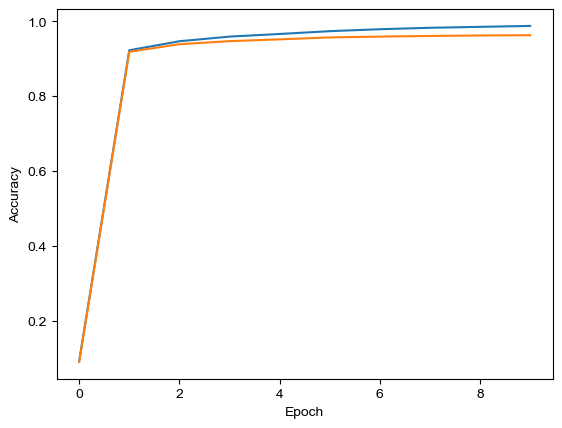

In [134]:
num_epochs = 10
num_pixels = 28*28
num_labels = 10
sizes = [num_pixels, 2000, num_labels]
key = jax.random.key(0)
net_params = init_network_layers(sizes, key)
thresholds = [-1.0, 1.0]
noise_sd = 0.1
opt_state = optimizer.init(net_params)

# keep track of accuracies
train_accs = []
valid_accs = []
train_loss = []


for epoch in tqdm(range(num_epochs)):
    # print accuracies on train and validation
    train_acc = accuracy(net_params, train_images.reshape(-1, num_pixels), train_labels, thresholds, key, noise_sd)
    valid_acc = accuracy(net_params, val_images.reshape(-1, num_pixels), val_labels, thresholds, key, noise_sd)
    print(f"Epoch {epoch}, Train Acc: {train_acc}, Valid Acc: {valid_acc}")

    train_accs.append(train_acc)
    valid_accs.append(valid_acc)

    # get the batches!!
    for image, label in get_train_batches(train_images, train_labels, BATCH_SIZE):
        image = jnp.reshape(image, (len(image), num_pixels))
        y = jax.nn.one_hot(label, num_labels)
        net_params, opt_state, loss = update_with_sgd(net_params, image, y, thresholds, noise_sd, opt_state)
        train_loss.append(loss)
        # print(f"Train loss: {loss}")


## plot the accuracies
plt.plot(train_accs, label = 'Train Accuracy')
plt.plot(valid_accs, label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')





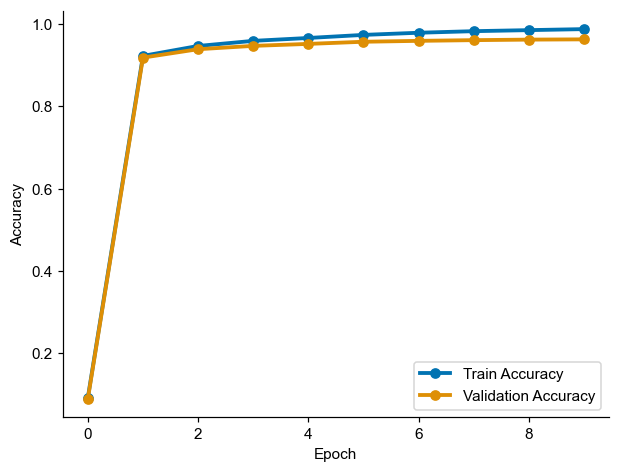

In [138]:
## neater plots
pal_cb = sns.color_palette('colorblind', 8)
fig, ax = plt.subplots(dpi = 110)
ax.plot(train_accs, label = 'Train Accuracy', c = pal_cb[0], lw = 2.5, marker = 'o')
ax.plot(valid_accs, label = 'Validation Accuracy', c = pal_cb[1], lw = 2.5, marker = 'o')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()

sns.despine()

In [139]:
## print the test set accuracy
test_acc = accuracy(net_params, test_images.reshape(-1, num_pixels), test_labels, thresholds, key, noise_sd)
print(f"Test-set accuracy = {test_acc*100:.2f}%")

Test-set accuracy = 96.33%
